TODO
1. Convert data to continous # done
2. Experiment with cross entropy likelihood vs Gaussian Likelihood # done
3. Investigate Gaussian log p calculation with reduce axis and reshape methods (math and experiemntal) 
4. experiment simple dataset first (mnist, cifar10) with different likelihoods
5. change the posteriors to GMM and start with making sure k=1 is the same as original single gaussian posterior
7. investigate how to determine the best latent dim

In [1]:
# ref Gaussian Regression likelihood
# https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf

In [2]:
%config Completer.use_jedi = False
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import pandas as pd
import logging

In [3]:
tf.executing_eagerly()

True

In [4]:
logging.basicConfig(level = logging.INFO)
main_logger = logging.getLogger('Main_Logger')

In [5]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
type(train_images)

numpy.ndarray

In [8]:
# configs
channel = 0

In [9]:
def preprocess_images(images):

    if len(images.shape)==4:
        if images.shape[3]==3: # colored
            main_logger.info('Converting batched colored images dataset to grayscale')
            images = tf.image.rgb_to_grayscale(images)
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return images # np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_images = tf.convert_to_tensor(train_images,dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images,dtype=tf.float32)

In [10]:
train_size = train_images.shape[0]
batch_size = 16
test_size = test_images.shape[0]

In [11]:
train_images.shape,test_images.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [12]:
train_dataset = (tf.data.Dataset.from_tensor_slices(tf.cast(train_images,tf.float32))
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(tf.cast(test_images,tf.float32))
                .shuffle(test_size).batch(batch_size))

In [13]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.logger = logging.getLogger('CVAE')
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )
        self.logger.info('Decoder')
        self.logger.info(self.decoder.summary())

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z):
        x_bar = self.decoder(z)
        return x_bar

In [14]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


def compute_loss(model, x):
    logger = logging.getLogger('compute_loss')
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_hat = model.decode(z)
    #main_logger.info(f'x = {x[0,:,:,0]}')
    #main_logger.debug(f'x shape = {x.shape}')
    #main_logger.debug(f'x type = {type(x)}')
    #main_logger.debug(f'x dtype = {x.dtype}')
    
    #main_logger.info(f'x_hat = {x_hat[0,:,:,0]}')
    #main_logger.debug(f'x_hat shape = {x_hat.shape}')
    #main_logger.debug(f'x_hat type = {type(x_hat)}')
    #main_logger.debug(f'x_hat dtype = {x_hat.dtype}')
    
#     cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x)
#     logpx_z =  -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

#     new_shape = (x.shape.as_list()[0],x.shape.as_list()[1]*x.shape.as_list()[2]*x.shape.as_list()[3])
#     x_rs = tf.reshape(x,new_shape)
#     x_hat_rs = tf.reshape(x_hat,new_shape)
    mse = tf.keras.losses.MSE(y_pred=x_hat,y_true=x)
    
    logpx_z_mse = -tf.reduce_sum(mse,axis=[1,2])
    
    # calc_diag_gaussian_log_likelihood(x=x,x_hat=x_hat)
    
    #main_logger.debug(f'logpx_z.shape = {logpx_z.shape}')
    logpz = log_normal_pdf(z, 0., 0.) # TODO, revisit
    logqz_x = log_normal_pdf(z, mean, logvar)
    
#     logger.info(f'Avg logp(x|z) cross_ent = {(tf.reduce_mean(logpx_z))}')
#     logger.info(f'Avg logp(x|z) gaussian = {(tf.reduce_mean(logpx_z_g))}')
#     logger.info(f'Avg logp(z|x) = {(tf.reduce_mean(logqz_x))}')
#     logger.info(f'Avg logp(z) = {(tf.reduce_mean(logpz))}')
#     logger.info('-----------------------')
    loss = -tf.reduce_mean(logpx_z_mse + logpz - logqz_x) # loss = -elbo
    #main_logger.debug(f'loss value = {loss}')
    return loss



def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [15]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 128
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

INFO:CVAE:Decoder
INFO:CVAE:None


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              202272    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 239,521
Trainable params: 239,521
Non-trainable params: 0
_________________________________________________________________


In [16]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(test_sample.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(test_sample[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()    
    for i in range(predictions.shape[0]):
        # main_logger.info(f'mean of predictions = {tf.reduce_mean(predictions[i])}')
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [17]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

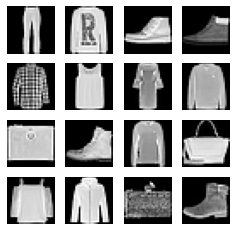

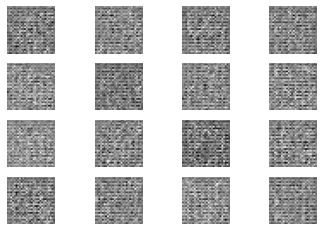

Epoch: 1, Test set ELBO: -37.17127227783203, time elapse for current epoch: 86.63366603851318


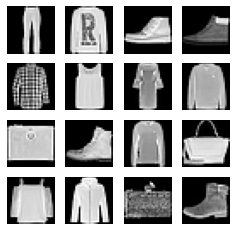

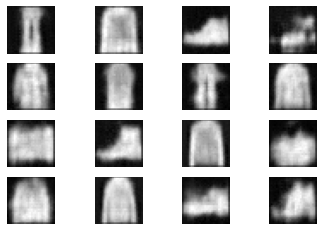

Epoch: 2, Test set ELBO: -33.70409393310547, time elapse for current epoch: 88.34811115264893


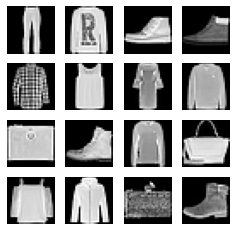

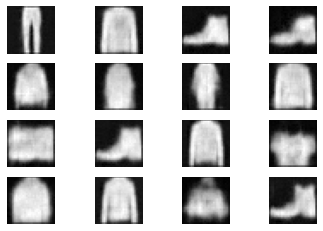

Epoch: 3, Test set ELBO: -31.516477584838867, time elapse for current epoch: 88.6809139251709


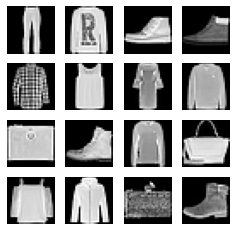

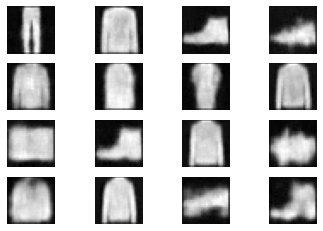

Epoch: 4, Test set ELBO: -30.2393741607666, time elapse for current epoch: 88.54242086410522


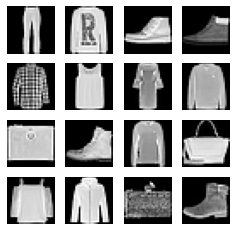

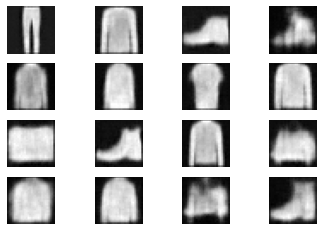

Epoch: 5, Test set ELBO: -29.179168701171875, time elapse for current epoch: 87.44812798500061


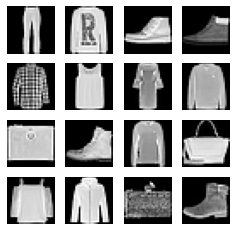

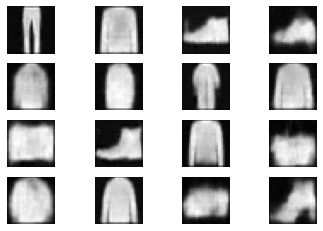

Epoch: 6, Test set ELBO: -28.322763442993164, time elapse for current epoch: 88.60500812530518


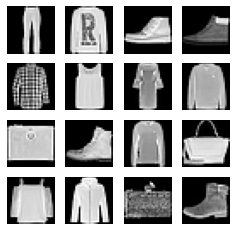

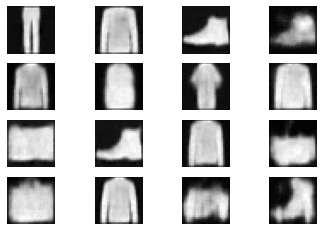

Epoch: 7, Test set ELBO: -27.81639289855957, time elapse for current epoch: 87.56839513778687


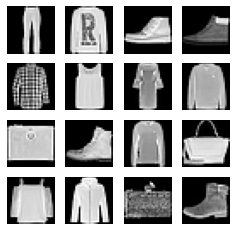

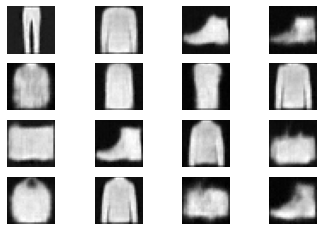

Epoch: 8, Test set ELBO: -27.410343170166016, time elapse for current epoch: 808.4135591983795


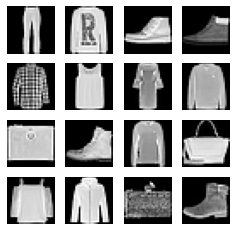

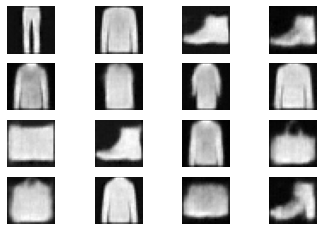

Epoch: 9, Test set ELBO: -27.09575843811035, time elapse for current epoch: 89.1323082447052


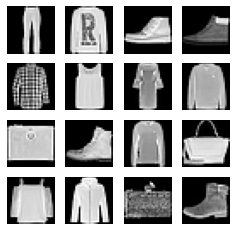

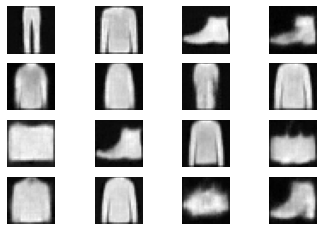

Epoch: 10, Test set ELBO: -26.77228355407715, time elapse for current epoch: 86.99557900428772


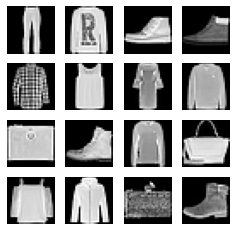

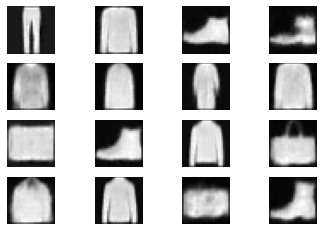

In [18]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    train_batches = int(train_images.shape[0]/batch_size)
    for i in range(train_batches):
        train_batch = train_images[i*batch_size:(i+1)*batch_size,:,:,:]
        train_step(model, train_batch, optimizer)
    end_time = time.time()
    
    
    loss = tf.keras.metrics.Mean()
    
    test_batches = int(test_images.shape[0]/batch_size)
    for j in range(test_batches):
        test_batch = test_images[j*batch_size:(j+1)*batch_size,:,:,:]
        loss(compute_loss(model, test_batch))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
          .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)